In [17]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np

In [18]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [19]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [27]:
def calculate_fid(real_features, generated_features):
    """
    Calculate the Frechet Inception Distance (FID) between real and generated features.

    Parameters
    ----------
    real_features: np.ndarray
        Features extracted from real images (N_real, D).
    generated_features: np.ndarray
        Features extracted from generated images (N_gen, D).

    Returns
    -------
    float
        FID score.
    """
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Compute squared difference of means
    mean_diff = np.sum((mu_real - mu_gen) ** 2)

    # Compute sqrt of product of covariance matrices
    cov_sqrt, _ = sqrtm(sigma_real @ sigma_gen, disp=False)

    # Handle numerical instabilities
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    fid = mean_diff + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    return fid

# Pre-trained Inception model (for FID calculation)
inception = inception_v3(pretrained=True, transform_input=False).eval()
for param in inception.parameters():
    param.requires_grad = False

def extract_features(images, inception_model, device):
    """
    Extract features from a batch of images using InceptionV3.

    Parameters
    ----------
    images: torch.Tensor
        Batch of images (N, C, H, W).
    inception_model: nn.Module
        Pre-trained Inception model.
    device: torch.device
        Device to use for feature extraction.

    Returns
    -------
    np.ndarray
        Extracted features (N, D).
    """
    inception_model = inception_model.to(device)  # Ensure model is on the correct device
    with torch.no_grad():
        # Check if images are flattened and reshape to (N, C, H, W)
        if images.dim() == 2:  # Shape is [N, D]
            side = int(images.shape[1] ** 0.5)
            images = images.view(-1, 1, side, side)

        if images.shape[1] == 1:  # Convert grayscale to RGB
            images = images.repeat(1, 3, 1, 1)

        images = images.to(device)  # Ensure input is on the correct device
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        features = inception_model(images)
        features = features.detach().cpu().numpy()  # Move features to CPU for numpy
    return features


# Function to calculate FID during training
def calculate_fid_for_model(model, dataloader, device, num_samples=1000):
    """
    Calculate FID score for the model.

    Parameters
    ----------
    model: nn.Module
        Trained model to generate images.
    dataloader: DataLoader
        DataLoader for the real dataset.
    device: torch.device
        Device to use (CPU or GPU).
    num_samples: int
        Number of samples to use for FID calculation.

    Returns
    -------
    float
        FID score.
    """
    real_features, gen_features = [], []

    # Extract features from real images
    for i, (real_images, _) in enumerate(dataloader):
        if len(real_features) >= num_samples:
            break

        real_images = real_images.to(device)
        real_features.append(extract_features(real_images, inception, device))

    real_features = np.concatenate(real_features[:num_samples], axis=0)

    # Generate and extract features from synthetic images
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples // dataloader.batch_size):
            generated_images = model.sample((dataloader.batch_size, 28 * 28)).view(-1, 1, 28, 28)
            # Map pixel values back from [-1,1] to [0,1]
            #generated_images = (generated_images+1)/2
            #generated_images = generated_images.clamp(0.0, 1.0)
            gen_features.append(extract_features(generated_images, inception, device))

    gen_features = np.concatenate(gen_features, axis=0)

    # Compute FID
    fid_score = calculate_fid(real_features, gen_features)
    return fid_score


Training:   0%|          | 0/11750 [00:00<?, ?it/s]

Epoch 1/50, FID: 9363.7192


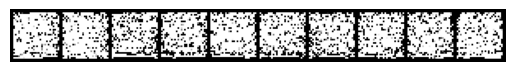

Epoch 2/50, FID: 1251.3394


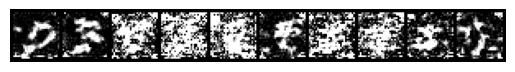

Epoch 3/50, FID: 995.5030


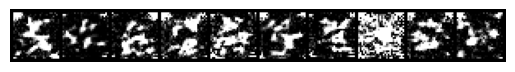

Epoch 4/50, FID: 846.1081


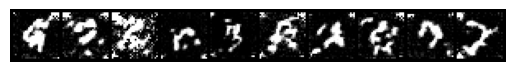

Epoch 5/50, FID: 786.6156


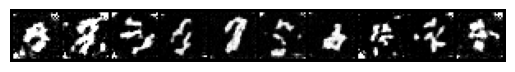

Epoch 6/50, FID: 735.5398


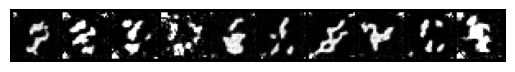

Epoch 7/50, FID: 711.6811


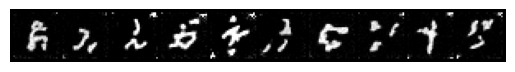

Epoch 8/50, FID: 670.0974


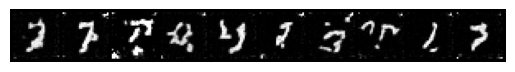

Epoch 9/50, FID: 656.2821


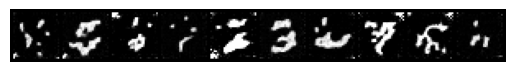

Epoch 10/50, FID: 628.7823


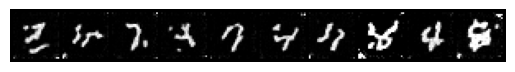

Epoch 11/50, FID: 634.8237


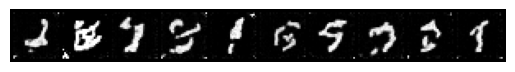

Epoch 12/50, FID: 708.1332


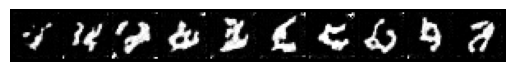

Epoch 13/50, FID: 613.7296


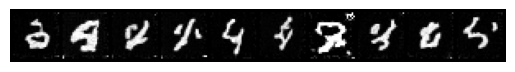

Epoch 14/50, FID: 605.7839


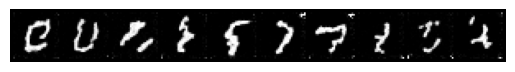

Epoch 15/50, FID: 628.5939


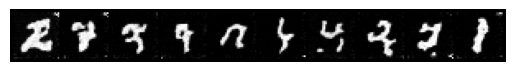

Epoch 16/50, FID: 601.1217


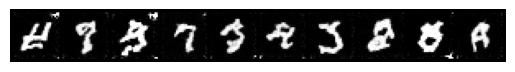

Epoch 17/50, FID: 665.1565


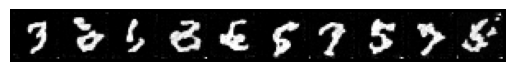

Epoch 18/50, FID: 584.1173


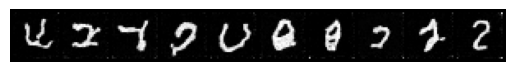

Epoch 19/50, FID: 554.5587


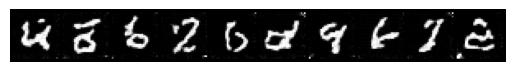

Epoch 20/50, FID: 626.3456


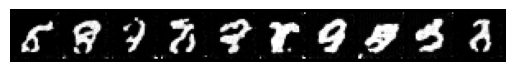

Epoch 21/50, FID: 528.7934


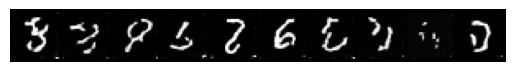

Epoch 22/50, FID: 510.4326


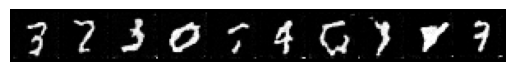

Epoch 23/50, FID: 490.5058


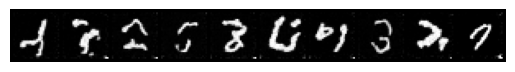

Epoch 24/50, FID: 483.9896


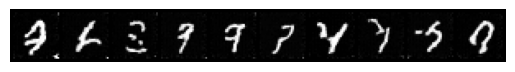

Epoch 25/50, FID: 473.4729


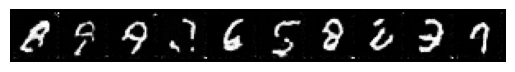

Epoch 26/50, FID: 623.8766


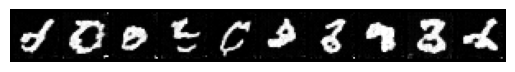

Epoch 27/50, FID: 534.4910


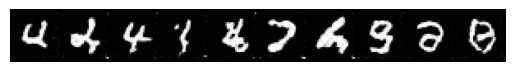

Epoch 28/50, FID: 429.3468


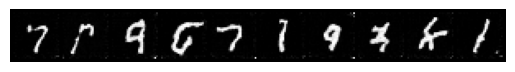

Epoch 29/50, FID: 472.1272


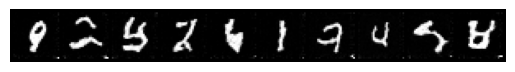

Epoch 30/50, FID: 472.0873


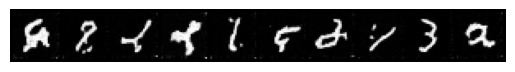

Epoch 31/50, FID: 487.4951


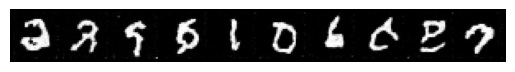

Epoch 32/50, FID: 403.5516


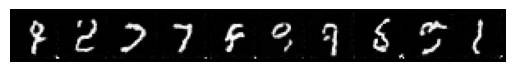

Epoch 33/50, FID: 565.0018


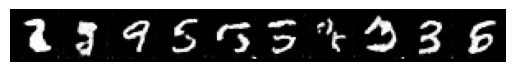

Epoch 34/50, FID: 389.2932


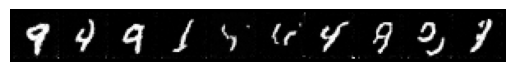

Epoch 35/50, FID: 454.6095


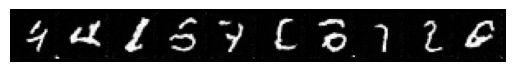

Epoch 36/50, FID: 399.1040


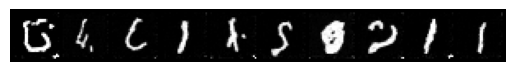

Epoch 37/50, FID: 438.2784


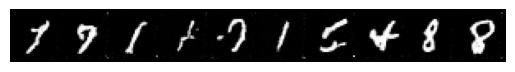

Epoch 38/50, FID: 433.2030


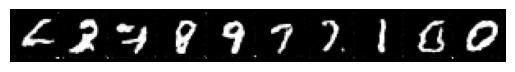

Epoch 39/50, FID: 474.1654


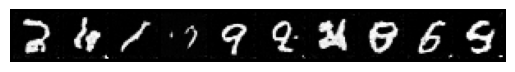

Epoch 40/50, FID: 461.1422


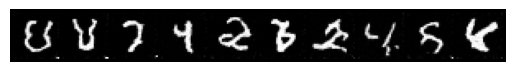

Epoch 41/50, FID: 382.0836


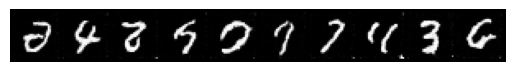

Epoch 42/50, FID: 434.1650


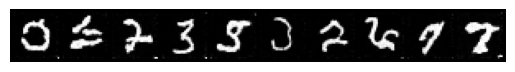

Epoch 43/50, FID: 428.3480


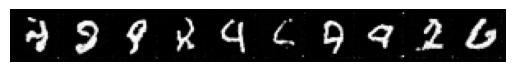

Epoch 44/50, FID: 359.7862


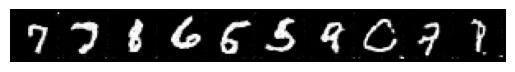

Epoch 45/50, FID: 362.7830


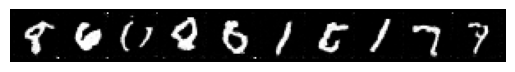

Epoch 46/50, FID: 434.7429


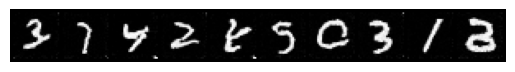

Epoch 47/50, FID: 437.8579


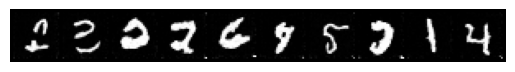

Epoch 48/50, FID: 399.7310


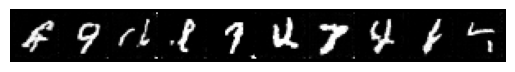

Epoch 49/50, FID: 385.3421


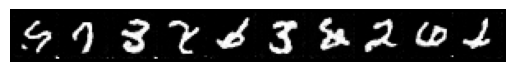

Epoch 50/50, FID: 429.7376


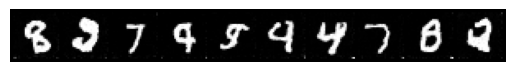

In [29]:
class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt


    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return  (1/2*self.alpha[t]*(1-self.alpha_bar[t]))*(-nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t)))


    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train_with_fid(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None, fid_interval=1):
    """
    Training loop with periodic FID calculation.

    Parameters
    ----------
    fid_interval : int
        Number of epochs between FID calculations.
    """
    total_steps = len(dataloader) * epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_model = ExponentialMovingAverage(model, device=device, decay=0.995)

    fid_scores = []
    epochs_list = []

    for epoch in range(epochs):
        model.train()
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", epoch=f"{epoch + 1}/{epochs}")
            progress_bar.update()

        if ema:
            ema_model.update_parameters(model)

        # FID calculation every fid_interval epochs
        if (epoch + 1) % fid_interval == 0:
            fid = calculate_fid_for_model(model, dataloader, device)
            fid_scores.append(fid)
            epochs_list.append(epoch + 1)
            print(f"Epoch {epoch + 1}/{epochs}, FID: {fid:.4f}")

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)

        fid_data = {
            "epochs": epochs_list,
            "fid_scores": fid_scores
        }
    return fid_data

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 50
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

# Call training loop
fid_data = train_with_fid(model, optimizer, scheduler, dataloader_train,
               epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)



In [31]:
import json

# Save the list to a JSON file
with open('fid_data.json', 'w') as f:
    json.dump(fid_data, f)

In [33]:
from google.colab import files
files.download('fid_data.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>